# Stein Variational Gradient Descent 

In this notebook, we will demonstrate how to implement *Stein Variational Gradient Descent (SVGD)* for Bayesian Deep Learning (BDL). 

SVGD is a particle-based, non-parametric algorithm that iteratively refines a set of particles to approximate the posterior distribution in Bayesian models. Unlike traditional variational inference methods which often rely on parametric forms of the posterior, SVGD uses a set of particles and updates them based on a combination of the gradient of the log posterior and a repulsive force derived from a kernel function. 

This approach allows for more flexible and potentially more accurate approximations of complex posteriors, such as those encountered in Bayesian Neural Networks (BNNs). Our focus will be on applying SVGD to optimize the posterior distribution of a BNN, leveraging its ability to capture complex, multimodal distributions without the need for specifying a parametric form upfront.

## What is SVGD Doing? 
Let \(\left\{\mathbf{x}_i\right\}_{i=1}^n\) be a set of \(n\) particles approximating the target distribution \(p(\mathbf{x})\). The update rule for each particle \(\mathbf{x}_i\) at iteration \(t\) is given by:
$$
\mathbf{x}_i^{(t+1)} = \mathbf{x}_i^{(t)} + \epsilon \hat{\phi}^*\left(\mathbf{x}_i^{(t)}\right)
$$
where \(\epsilon\) is the step size, and \(\hat{\phi}^*\) is the SVGD update direction calculated as:
$$
\hat{\phi}^*(\mathbf{x}) = \frac{1}{n} \sum_{j=1}^n \left[ \underbrace{k\left(\mathbf{x}_j, \mathbf{x}\right) \nabla_{\mathbf{x}_j} \log p\left(\mathbf{x}_j\right)}_{\text{Attractive Term}} + \underbrace{\nabla_{\mathbf{x}_j} k\left(\mathbf{x}_j, \mathbf{x}\right)}_{\text{Repulsive Term}} \right]
$$

In this equation:
- \( k(\mathbf{x}, \mathbf{y}) \) is a positive definite kernel function, such as the RBF kernel.
- \( \nabla_{\mathbf{x}_j} \log p\left(\mathbf{x}_j\right) \) is the gradient of the log of the target distribution \( p \) with respect to the particle \( \mathbf{x}_j \).
- \( \nabla_{\mathbf{x}_j} k\left(\mathbf{x}_j, \mathbf{x}\right) \) is the gradient of the kernel function with respect to \( \mathbf{x}_j \).


### Setting up the Dataset

We will use the sine wave dataset from the [introductory tutorial](https://lbai-push.readthedocs.io/en/latest/tutorials/01_Bayesian_Deep_Learning/bayesian_deep_learning.html): Sampling the dataset on the interval $(-2\pi, 2\pi)$

$$
\begin{align}
    y & = sin(x) + \epsilon \\
    \epsilon & \sim \mathcal{N}(0, 0.05) \,.
\end{align}
$$

The code for `SineWithNoiseDataset` is contained in the module `bdl`.

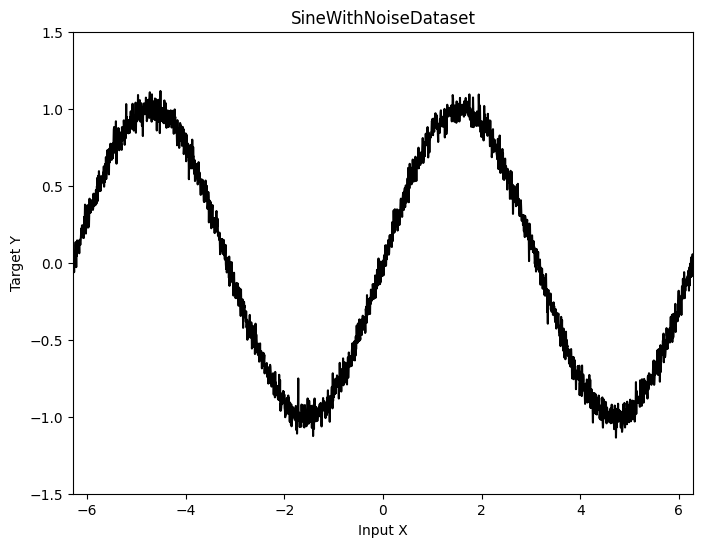

In [ ]:
import math
import matplotlib.pyplot as plt

import sys
import os
parent_dir = os.path.dirname(os.getcwd())  
target_dir = os.path.join(parent_dir, "02_Multi_SWAG")  
sys.path.append(target_dir)
from bdl import SineWithNoiseDataset

D = 1                                  # dimensions
N = 2048                               # number of points
train_begin_radians = -2 * math.pi     # left interval
train_end_radians = 2 * math.pi        # right interval

# Define the dataset as a PyTorch dataset
dataset = SineWithNoiseDataset(N, D, train_begin_radians, train_end_radians)

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.plot(dataset.xs, dataset.ys, c ='black')
plt.title('Sine With Noise Dataset')
plt.xlabel('Input X')
plt.ylabel('Target Y')
plt.xlim(train_begin_radians, train_end_radians)
plt.ylim(-1.5, 1.5)
plt.show()

## Defining the Model

We will use the same NN architectures `MiniNN` and `BiggerNN` that we used in the [introductory tutorial](https://lbai-push.readthedocs.io/en/latest/tutorials/01_Bayesian_Deep_Learning/bayesian_deep_learning.html). The code for `MiniNN` and `BiggerNN` is contained in the module `bdl`.

In [2]:
from bdl import MiniNN, BiggerNN

## Implementing SVGD with Push
In this section, we utilize Push's `train_svgd` function, located in the `bayes/stein_vgd` directory, to apply Stein Variational Gradient Descent (SVGD) for optimizing Bayesian Neural Network parameters. 

- `train_svgd` initializes a `SteinVGD` instance and performs Bayesian inference using the provided data loader, loss function, and training parameters.

In [3]:
import torch
from torch.utils.data import DataLoader
import push.bayes.stein_vgd

batch_size = 512
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
input_dim = 1
output_dim = 1
hidden_dim = 64
n = 4
epochs = 2000
devices = 2

In [4]:
two_particle_svgd = push.bayes.stein_vgd.train_svgd(
            dataloader, torch.nn.MSELoss(),
            epochs, 2,
            BiggerNN, n, input_dim, output_dim, hidden_dim,
            lengthscale=0.5, lr=1e-2
        )

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [03:13<00:00, 10.33it/s]


In [5]:
four_particle_svgd = push.bayes.stein_vgd.train_svgd(
            dataloader, torch.nn.MSELoss(),
            epochs, 4,
            BiggerNN, n, input_dim, output_dim, hidden_dim,
            lengthscale=0.5, lr=1e-2
        )

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [05:42<00:00,  5.84it/s]


In [6]:
eight_particle_svgd = push.bayes.stein_vgd.train_svgd(
            dataloader, torch.nn.MSELoss(),
            epochs, 8,
            BiggerNN, n, input_dim, output_dim, hidden_dim,
            lengthscale=0.5, lr=1e-2
        )

  0%|          | 0/2000 [00:00<?, ?it/s]

 13%|█▎        | 252/2000 [04:00<27:39,  1.05it/s]

## Posterior Predictive Inference

Now that we have successfully trained a few models with SVGD, we can make predictions with the model. We create a test dataset first. 

### Test Data

Like we did in the [introductory tutorial](https://lbai-push.readthedocs.io/en/latest/tutorials/01_Bayesian_Deep_Learning/bayesian_deep_learning.html), we set up the test dataset now with the sine wave of $D = 1$ dimensions defined on the interval $(-8\pi, 8\pi)$ with $N = 2048$ data points to check the out-of-distribution predictions obtained by SVGD.

In [ ]:
import numpy as np
test_begin_radians = -8 * math.pi
test_end_radians = 8 * math.pi

test_dataset = SineWithNoiseDataset(N, D, test_begin_radians, test_end_radians)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
test_dataset_xs = test_dataset.xs
test_dataset_ys = test_dataset.ys

# Extract the data
xs = dataset.xs
ys = dataset.ys

## Performing Inference
The `SteinVGD` class implements the `posterior_pred` function which can compute the mean, standard deviation, median, min, max predictions over our `PusH` distribution's particles. Inference is handled on the particle level, with each particle performing inference concurrently. 

With our `SteinVGD` object obtained from training we will pass in our test dataloader to the `posterior_pred` and specify the `mode`(s) of prediction we would like (mean, median, min, max, and/or std), we indicate whether this is a regression task with `f_reg`.

`posterior_pred` returns a `dict` containing prediction results, with the selected `mode` values as keys.

In [ ]:
two_particle_svgd_prediction = two_particle_svgd.posterior_pred(test_dataloader, mode=["mean", "std"])
four_particle_svgd_prediction = four_particle_svgd.posterior_pred(test_dataloader, mode=["mean", "std"])
eight_particle_svgd_prediction = eight_particle_svgd.posterior_pred(test_dataloader, mode=["mean", "std"])

### Plotting our Results

In [ ]:
import matplotlib.pyplot as plt

def plot_svgd_prediction(svgd_output, test_dataset_xs, test_dataset_ys, train_begin_radians, train_end_radians, test_begin_radians, test_end_radians):
    plt.figure(figsize=(8, 6))
    pred_upper = svgd_output["mean"] + svgd_output["std"]
    pred_lower = svgd_output["mean"] - svgd_output["std"]
    plt.plot(test_dataset_xs, test_dataset_ys, c="black", label="Ground Truth")
    plt.plot(test_dataset_xs, svgd_output["mean"], color="blue", lw=2, label="Mean Prediction")
    plt.plot(test_dataset_xs, pred_upper, "-b", alpha=0.5, lw=1)
    plt.plot(test_dataset_xs, pred_lower, "-b", alpha=0.5, lw=1)
    plt.fill_between(test_dataset_xs.view(-1).numpy(), pred_lower.flatten(), pred_upper.flatten(), color='blue', alpha=0.3)
    plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
    plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
    plt.xlim(test_begin_radians, test_end_radians)
    plt.ylim(-1.5, 1.5)
    plt.title('Two-Particle SVGD')
    plt.xlabel('X')
    plt.ylabel('Target (Y)')
    plt.legend()
    plt.show()


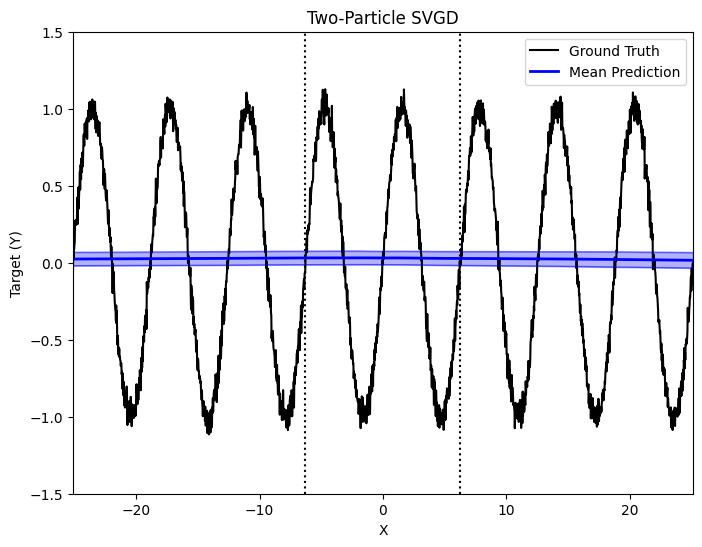

In [ ]:
plot_svgd_prediction(two_particle_svgd_prediction, test_dataset_xs, test_dataset_ys, train_begin_radians, train_end_radians, test_begin_radians, test_end_radians)
plot_svgd_prediction(four_particle_svgd_prediction, test_dataset_xs, test_dataset_ys, train_begin_radians, train_end_radians, test_begin_radians, test_end_radians)
plot_svgd_prediction(eight_particle_svgd_prediction, test_dataset_xs, test_dataset_ys, train_begin_radians, train_end_radians, test_begin_radians, test_end_radians)